In [ ]:
# Install PySpark
!pip install pyspark

# Import and create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("New York Crime Analysis").getOrCreate()


We have installed pyspark

**Loading the Dataset**

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in Google Drive
file_path = "/content/drive/My Drive/NYPD_Data/NYPD_Complaint_Data_Historic.csv"




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import pandas
import pandas as pd # data processing and manipulation

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load a sample (100,0000 records) of the dataset into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True).limit(10000000)

# Show the DataFrame schema and the first few rows
df.printSchema()
df.show(5)

root
 |-- CMPLNT_NUM: string (nullable = true)
 |-- CMPLNT_FR_DT: string (nullable = true)
 |-- CMPLNT_FR_TM: string (nullable = true)
 |-- CMPLNT_TO_DT: string (nullable = true)
 |-- CMPLNT_TO_TM: string (nullable = true)
 |-- ADDR_PCT_CD: integer (nullable = true)
 |-- RPT_DT: string (nullable = true)
 |-- KY_CD: integer (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- PD_CD: integer (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- CRM_ATPT_CPTD_CD: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- LOC_OF_OCCUR_DESC: string (nullable = true)
 |-- PREM_TYP_DESC: string (nullable = true)
 |-- JURIS_DESC: string (nullable = true)
 |-- JURISDICTION_CODE: integer (nullable = true)
 |-- PARKS_NM: string (nullable = true)
 |-- HADEVELOPT: string (nullable = true)
 |-- HOUSING_PSA: string (nullable = true)
 |-- X_COORD_CD: integer (nullable = true)
 |-- Y_COORD_CD: integer (nullable = true)
 |-- SUSP_AGE

In [ ]:
column_names = df.columns
print(column_names)


['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE', 'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX']


In [ ]:
df.count()

9491946

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Cleaning**

In [ ]:
from pyspark.sql.functions import col, count, isnan, when
from pyspark.sql.types import DoubleType, FloatType

def calculate_missing_values(df):
    analysis_columns = []

    for field in df.schema.fields:
        col_name = field.name
        col_type = field.dataType

        # Check for missing values differently based on data type
        if isinstance(col_type, (DoubleType, FloatType)):
            analysis_columns.append(((count(when(isnan(col_name) | col(col_name).isNull(), col_name)) / count(col_name)) * 100).alias(col_name))
        else:
            analysis_columns.append(((count(when(col(col_name).isNull(), col_name)) / count(col_name)) * 100).alias(col_name))

    return df.select(analysis_columns)

missing_values_df = calculate_missing_values(df)
missing_values_df.show()


+----------+--------------------+------------+------------------+------------+--------------------+------+-----+---------+-------------------+-------+----------------+----------+-------+--------------------+-------------+----------+-----------------+--------+----------+-----------------+--------------------+--------------------+--------------+---------+--------+-----------------+--------------------+--------------------+--------------------+-----------+------------+-------------+--------+-------+
|CMPLNT_NUM|        CMPLNT_FR_DT|CMPLNT_FR_TM|      CMPLNT_TO_DT|CMPLNT_TO_TM|         ADDR_PCT_CD|RPT_DT|KY_CD|OFNS_DESC|              PD_CD|PD_DESC|CRM_ATPT_CPTD_CD|LAW_CAT_CD|BORO_NM|   LOC_OF_OCCUR_DESC|PREM_TYP_DESC|JURIS_DESC|JURISDICTION_CODE|PARKS_NM|HADEVELOPT|      HOUSING_PSA|          X_COORD_CD|          Y_COORD_CD|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX| TRANSIT_DISTRICT|            Latitude|           Longitude|             Lat_Lon|PATROL_BORO|STATION_NAME|VIC_AGE_GROUP|VIC_RACE|VIC_S

In [ ]:
# Define columns to drop and columns to fill with 'UNKNOWN'
drop_columns = ['PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'STATION_NAME', 'TRANSIT_DISTRICT']
fill_columns = {'SUSP_AGE_GROUP': 'UNKNOWN', 'SUSP_SEX': 'UNKNOWN', 'SUSP_RACE': 'UNKNOWN', 'VIC_AGE_GROUP': 'UNKNOWN', 'VIC_RACE': 'UNKNOWN', 'VIC_SEX': 'UNKNOWN'}

# Apply cleaning steps
df = df.drop(*drop_columns)  # Use * to unpack the list of column names
df = df.fillna(fill_columns)  # Use a dictionary for fillna


In [ ]:
# Dropping rows with NaN values in specified columns
df = df.dropna(subset=['Y_COORD_CD', 'X_COORD_CD', 'Latitude', 'Longitude', 'CRM_ATPT_CPTD_CD', 'CMPLNT_FR_TM', 'Lat_Lon', 'CMPLNT_FR_DT', 'BORO_NM', 'OFNS_DESC'])

# Dropping columns that are not significant for future data exploration
# Define the columns to keep (i.e., all columns except the ones you want to drop)
columns_to_keep = [col for col in df.columns if col not in ['PARKS_NM', 'STATION_NAME', 'TRANSIT_DISTRICT', 'HADEVELOPT', 'HOUSING_PSA', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_SEX', 'SUSP_RACE', 'JURISDICTION_CODE', 'ADDR_PCT_CD', 'PD_CD', 'PD_DESC', 'PATROL_BORO', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM']]

# Select only the columns to keep
df = df[columns_to_keep]

# Replacing all NaN values in specified columns with 'UNKNOWN'
fillna_columns = {'LOC_OF_OCCUR_DESC': 'UNKNOWN', 'VIC_RACE': 'UNKNOWN', 'VIC_AGE_GROUP': 'UNKNOWN', 'VIC_SEX': 'UNKNOWN'}
df = df.fillna(fillna_columns)

# Displaying the clean dataset information
print('Clean dataset:')
print(f"Observations: {df.count()}")
print(f"Variables: {len(df.columns)}")


# Examining the changes
df.head()


Clean dataset:
Observations: 9490812
Variables: 19


Row(CMPLNT_NUM='39468181', CMPLNT_FR_DT='02/20/2008', CMPLNT_FR_TM='07:00:00', RPT_DT='02/23/2008', KY_CD=107, OFNS_DESC='BURGLARY', CRM_ATPT_CPTD_CD='COMPLETED', LAW_CAT_CD='FELONY', BORO_NM='BROOKLYN', LOC_OF_OCCUR_DESC='INSIDE', JURIS_DESC='N.Y. POLICE DEPT', X_COORD_CD=991818, Y_COORD_CD=191560, Latitude=40.692464, Longitude=-73.972708, Lat_Lon='(40.692464, -73.972708)', VIC_AGE_GROUP='25-44', VIC_RACE='WHITE', VIC_SEX='F')

In [ ]:
df.show(5)


+----------+------------+------------+----------+-----+--------------+----------------+-----------+---------+-----------------+-------------------+----------+----------+---------+----------+--------------------+-------------+--------------+-------+
|CMPLNT_NUM|CMPLNT_FR_DT|CMPLNT_FR_TM|    RPT_DT|KY_CD|     OFNS_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|  BORO_NM|LOC_OF_OCCUR_DESC|         JURIS_DESC|X_COORD_CD|Y_COORD_CD| Latitude| Longitude|             Lat_Lon|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|
+----------+------------+------------+----------+-----+--------------+----------------+-----------+---------+-----------------+-------------------+----------+----------+---------+----------+--------------------+-------------+--------------+-------+
|  39468181|  02/20/2008|    07:00:00|02/23/2008|  107|      BURGLARY|       COMPLETED|     FELONY| BROOKLYN|           INSIDE|   N.Y. POLICE DEPT|    991818|    191560|40.692464|-73.972708|(40.692464, -73.9...|        25-44|         WHITE|      F|
|  5

In [20]:
from pyspark.sql.functions import col

# Group by 'OFNS_DESC', count, and order by the count
crime_counts = df.groupBy("OFNS_DESC").count().orderBy(col("count").desc())

# Show the top 30 crime types
crime_counts.show(30)


+--------------------+-------+
|           OFNS_DESC|  count|
+--------------------+-------+
|       PETIT LARCENY|1666606|
|       HARRASSMENT 2|1272880|
|ASSAULT 3 & RELAT...| 998256|
|CRIMINAL MISCHIEF...| 916170|
|       GRAND LARCENY| 831814|
|     DANGEROUS DRUGS| 471826|
|OFF. AGNST PUB OR...| 455116|
|      FELONY ASSAULT| 393337|
|             ROBBERY| 331476|
|            BURGLARY| 310231|
|MISCELLANEOUS PEN...| 252585|
|   DANGEROUS WEAPONS| 191021|
|GRAND LARCENY OF ...| 188090|
|OFFENSES AGAINST ...| 165393|
|VEHICLE AND TRAFF...| 161051|
|          SEX CRIMES| 121927|
|INTOXICATED & IMP...| 108453|
|             FORGERY|  95669|
|   CRIMINAL TRESPASS|  92304|
|         THEFT-FRAUD|  90476|
|              FRAUDS|  54145|
|POSSESSION OF STO...|  45129|
|OFFENSES INVOLVIN...|  35190|
|UNAUTHORIZED USE ...|  28039|
|                RAPE|  28025|
|OFFENSES AGAINST ...|  23729|
| ADMINISTRATIVE CODE|  22320|
|               ARSON|  20207|
|OTHER OFFENSES RE...|  20120|
|       

**Data Visualization**

Analysis 1: Crime Types Distribution


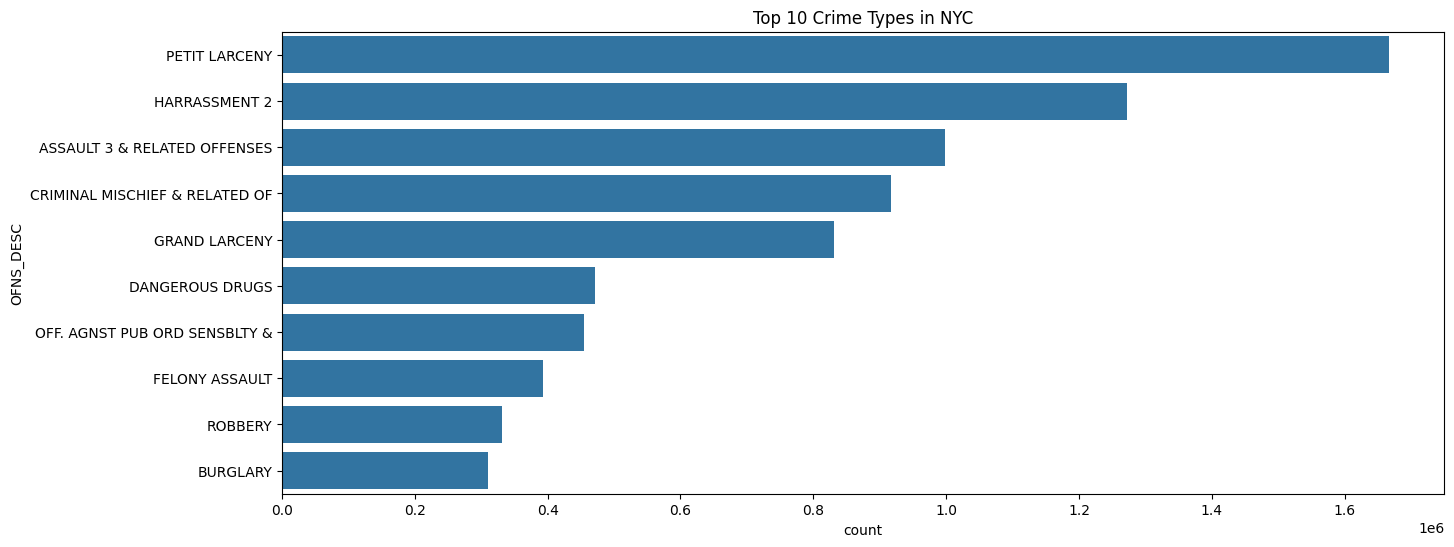

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the result to Pandas DataFrame
crime_counts_pd = crime_counts.toPandas()

# Visualize the top 10 crime types
plt.figure(figsize=(15, 6))
sns.barplot(x="count", y="OFNS_DESC", data=crime_counts_pd.head(10))
plt.title("Top 10 Crime Types in NYC")
plt.show()

This bar chart illustrates the top 10 crimes in NYC

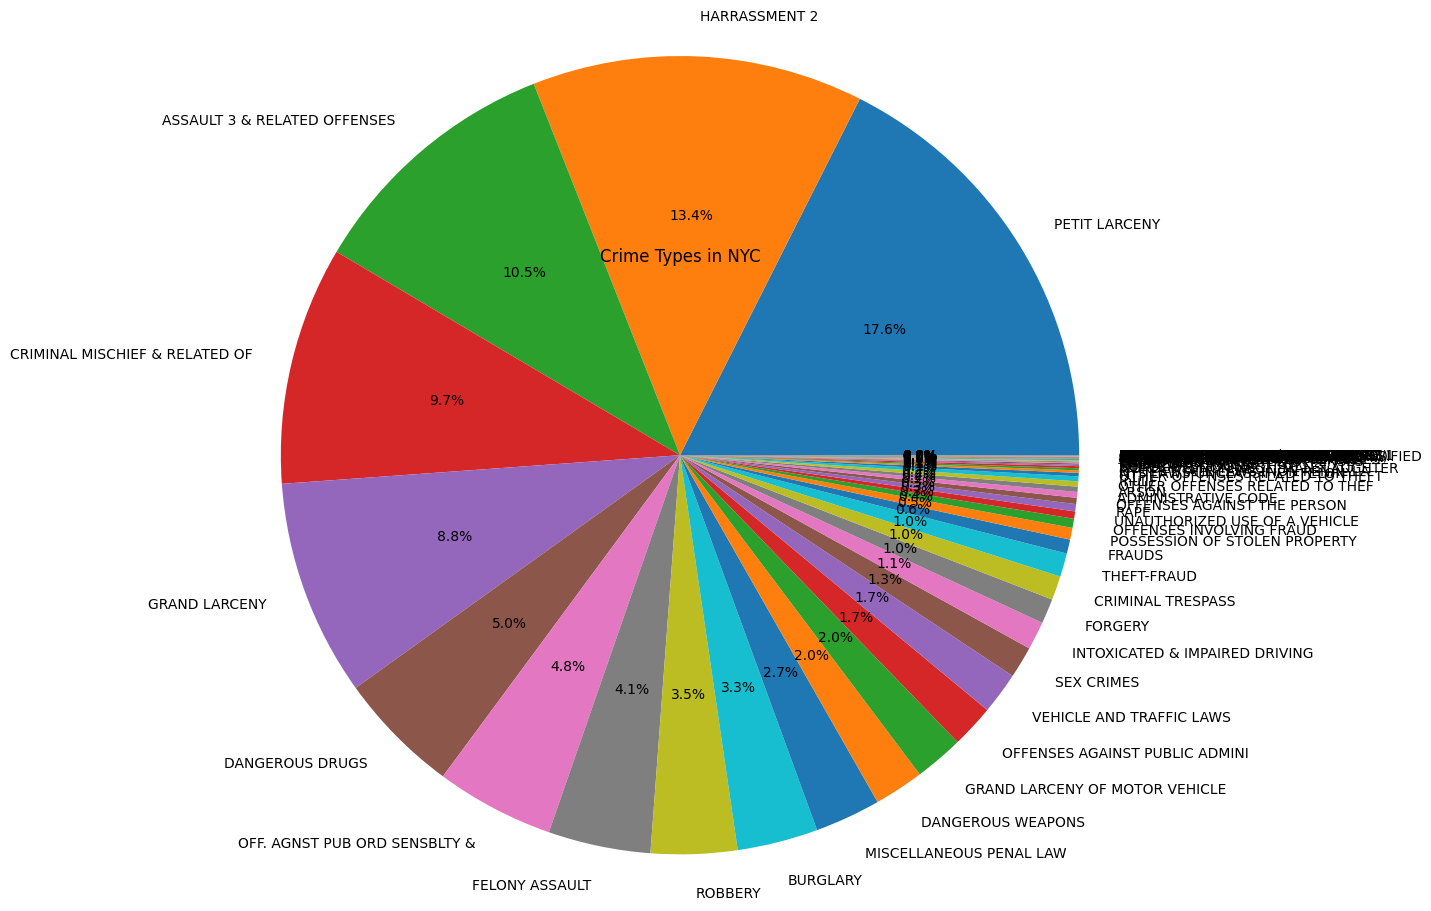

In [22]:
import matplotlib.pyplot as plt

# Plotting a pie chart
crime_counts_pd.set_index('OFNS_DESC')['count'].plot.pie(
    radius=2.7, autopct='%1.1f%%', textprops={'color': "black"}
)
plt.ylabel('')  # Hide y-label
plt.title('Crime Types in NYC')
plt.show()

Insight: This visualization will show which types of crimes are most common, providing a focus area for crime prevention efforts.


Analysis 2: Yearly Trend of Crimes

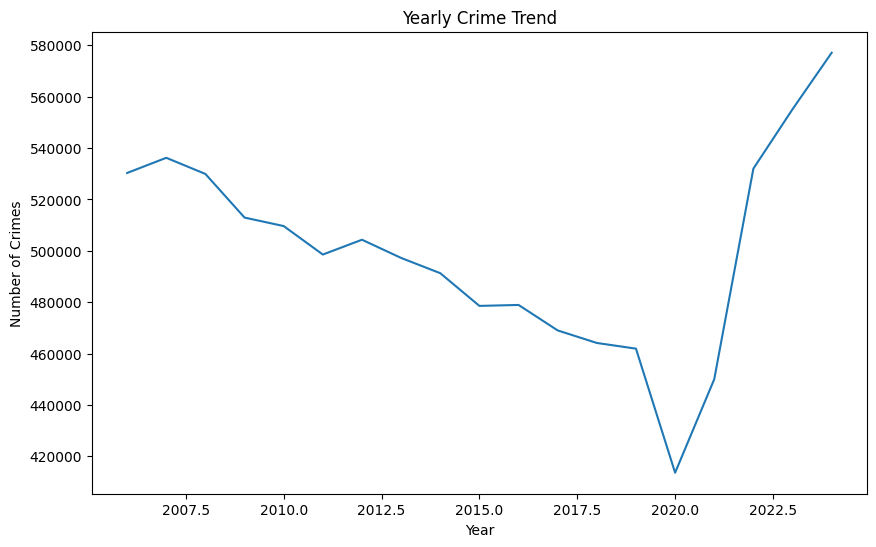

In [23]:
from pyspark.sql.functions import year,to_timestamp

# Convert to a correct timestamp format if necessary
df = df.withColumn('RPT_DT', to_timestamp('RPT_DT', 'MM/dd/yyyy'))

# Extract year and perform aggregation
yearly_trend = df.withColumn('Year', year('RPT_DT')).groupBy('Year').count().orderBy('Year')
yearly_trend_pd = yearly_trend.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_trend_pd, x='Year', y='count')
plt.title('Yearly Crime Trend')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()


Insight: This plot will reveal increasing, decreasing in the crime rates over the years

Analysis 3: Crime Occurrence by Day of Week

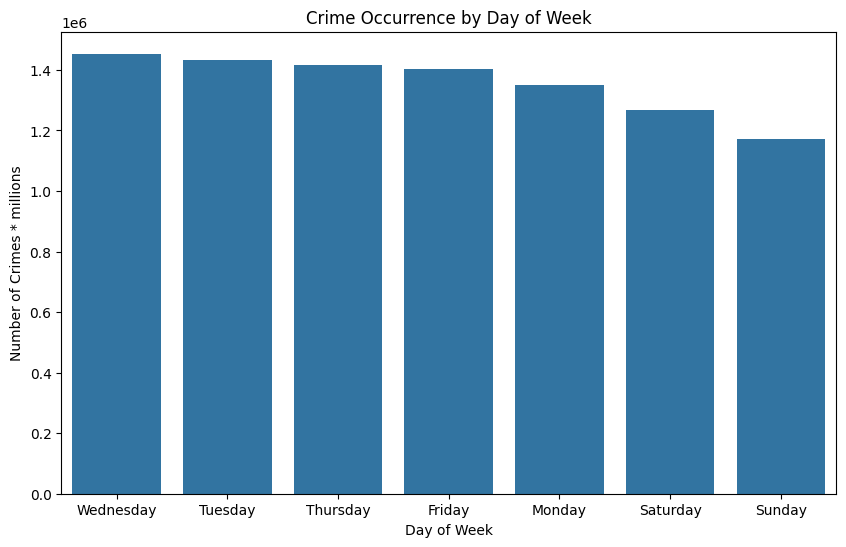

In [24]:
from pyspark.sql.functions import date_format

# Extracting day of the week
df = df.withColumn('DayOfWeek', date_format('RPT_DT', 'EEEE'))
day_of_week_distribution = df.groupBy('DayOfWeek').count().orderBy('count', ascending=False)
day_of_week_distribution_pd = day_of_week_distribution.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=day_of_week_distribution_pd, x='DayOfWeek', y='count')
plt.title('Crime Occurrence by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes * millions')
plt.show()


Insight: This analysis can indicate Wednesday,Tuesday, Thursday, Friday are the specific days of the week when crimes are more likely to occur.

Analysis 4: Crime Location Analysis

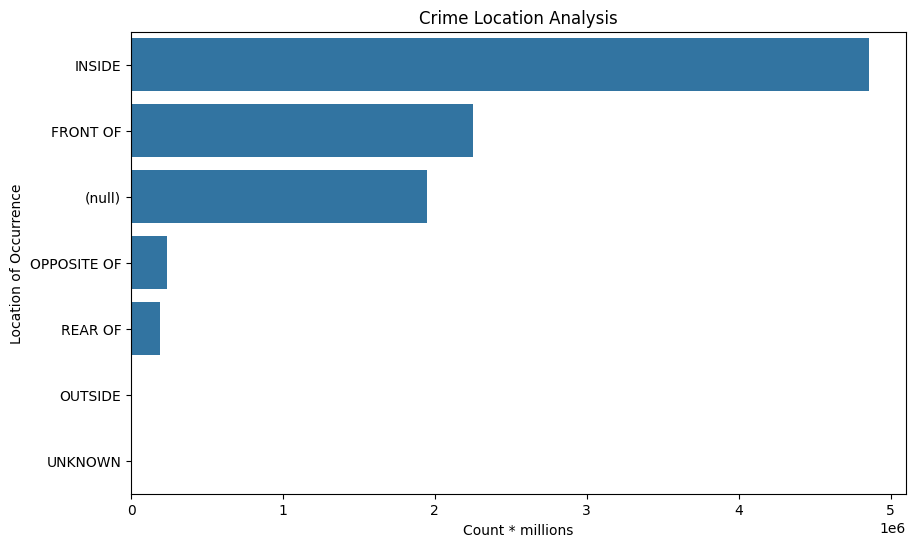

In [25]:
location_distribution = df.groupBy('LOC_OF_OCCUR_DESC').count().orderBy('count', ascending=False)
location_distribution_pd = location_distribution.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=location_distribution_pd, x='count', y='LOC_OF_OCCUR_DESC')
plt.title('Crime Location Analysis')
plt.xlabel('Count * millions')
plt.ylabel('Location of Occurrence')
plt.show()


Insight: Identifies crime hotspots and could be crucial for law enforcement resource allocation.

Analysis 5: Borough-wise Crime Analysis

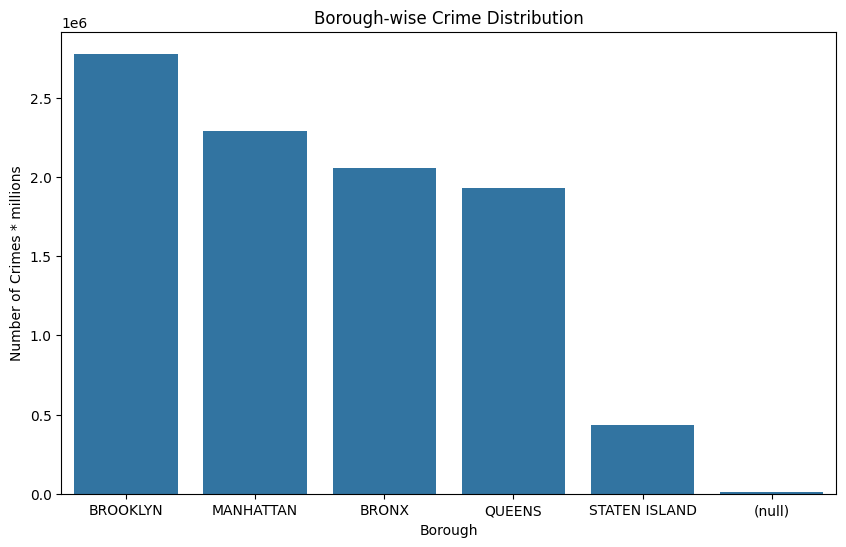

In [26]:
borough_distribution = df.groupBy('BORO_NM').count().orderBy('count', ascending=False)
borough_distribution_pd = borough_distribution.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=borough_distribution_pd, x='BORO_NM', y='count')
plt.title('Borough-wise Crime Distribution')
plt.xlabel('Borough')
plt.ylabel('Number of Crimes * millions')
plt.show()


Insight: Reveals brooklyn borough have higher crime rates and may need more attention.

Analysis 6: Analysis of Crime Completion Status(Completed vs Attempted).

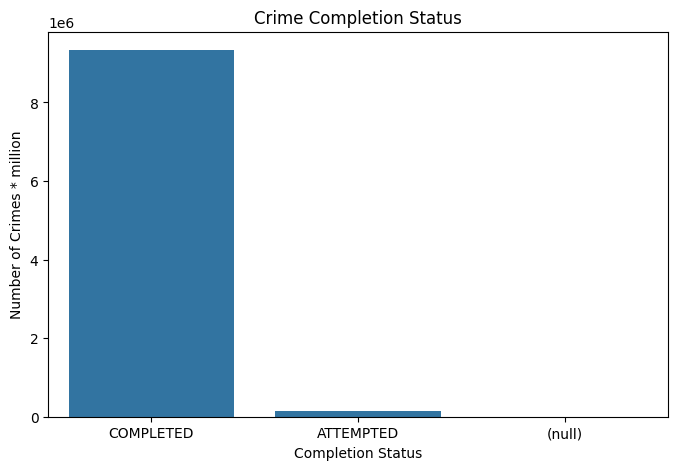

In [27]:
crime_completion_status = df.groupBy('CRM_ATPT_CPTD_CD').count().orderBy('count', ascending=False)
crime_completion_status_pd = crime_completion_status.toPandas()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=crime_completion_status_pd, x='CRM_ATPT_CPTD_CD', y='count')
plt.title('Crime Completion Status')
plt.xlabel('Completion Status')
plt.ylabel('Number of Crimes * million')
plt.show()


Insight: Provides an idea about the proportion of attempted versus successfully completed crimes.

Analysis 7: Crime Severity Analysis (Felony, Misdemeanor, Violation)

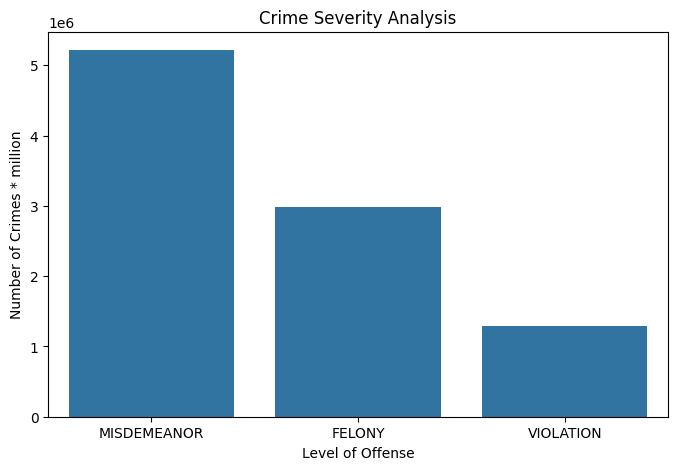

In [28]:
crime_severity = df.groupBy('LAW_CAT_CD').count().orderBy('count', ascending=False)
crime_severity_pd = crime_severity.toPandas()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=crime_severity_pd, x='LAW_CAT_CD', y='count')
plt.title('Crime Severity Analysis')
plt.xlabel('Level of Offense')
plt.ylabel('Number of Crimes * million')
plt.show()


Insight: This analysis will highlight the proportions of felonies, misdemeanors, and violations, offering insight into the severity of crimes being reported.

Analysis 8: Victim Age Group Analysis

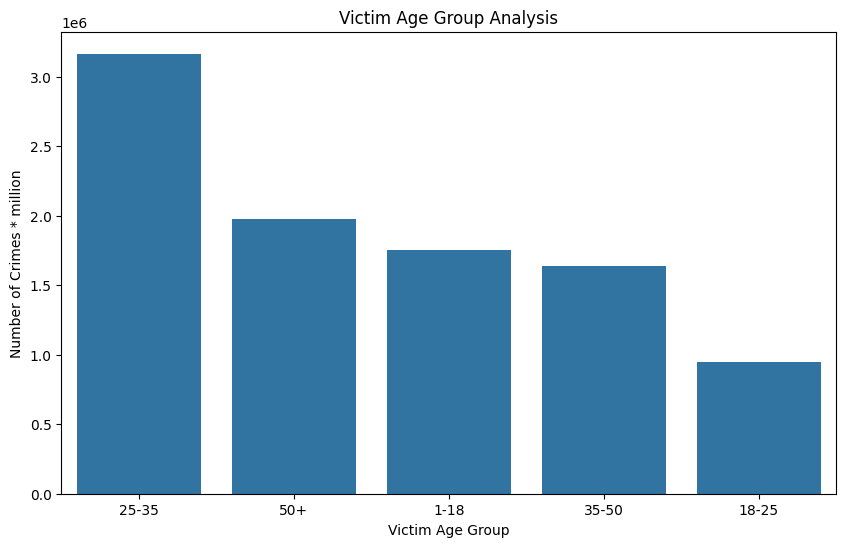

In [29]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import seaborn as sns


# UDF to categorize age
def categorize_age(age):
    if age in ['<18', 'UNKNOWN']:
        return '1-18'
    elif age in ['18-24']:
        return '18-25'
    elif age in ['25-44']:
        return '25-35'
    elif age in ['45-64']:
        return '35-50'
    else:
        return '50+'

categorize_age_udf = udf(categorize_age, StringType())

# Apply the categorization UDF
df = df.withColumn('Age_Category', categorize_age_udf(df['VIC_AGE_GROUP']))

# Group by the new category
victim_age_group = df.groupBy('Age_Category').count().orderBy('count', ascending=False)
victim_age_group_pd = victim_age_group.toPandas()


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=victim_age_group_pd, x='Age_Category', y='count')
plt.title('Victim Age Group Analysis')
plt.xlabel('Victim Age Group')
plt.ylabel('Number of Crimes * million')
plt.show()


Insight: Indicates which age groups are more vulnerable to being victims of crime.

Analysis 9: Victim Race Analysis

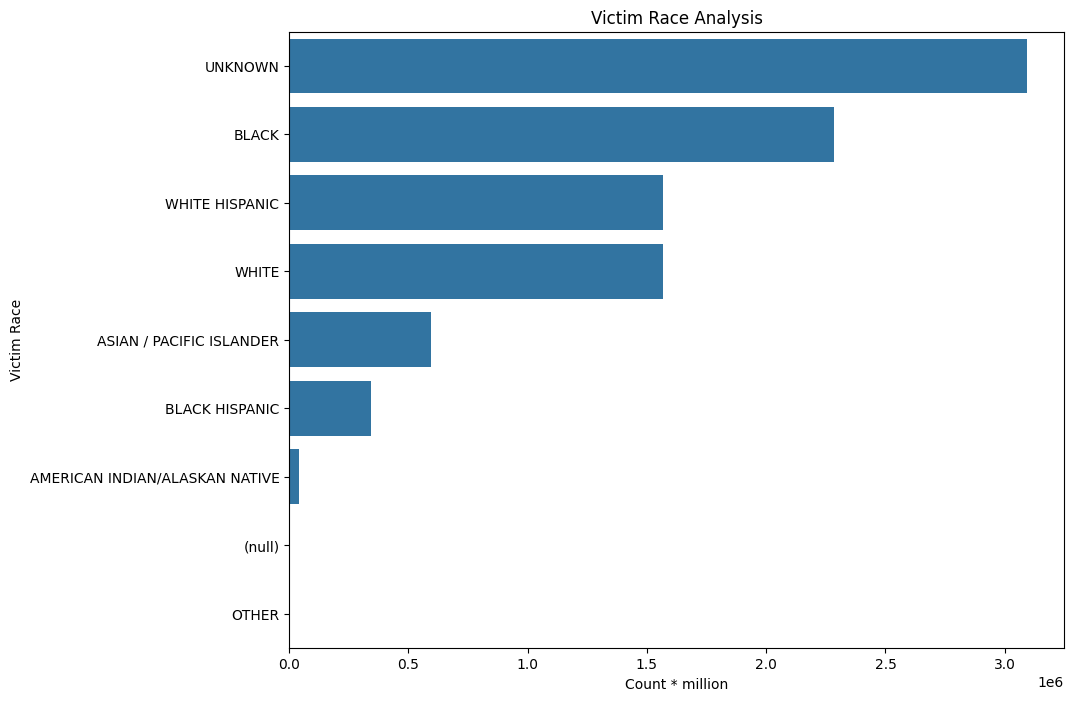

In [30]:
victim_race = df.groupBy('VIC_RACE').count().orderBy('count', ascending=False)
victim_race_pd = victim_race.toPandas()

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(data=victim_race_pd, x='count', y='VIC_RACE')
plt.title('Victim Race Analysis')
plt.xlabel('Count * million')
plt.ylabel('Victim Race')
plt.show()


Insight: Helps in understanding if certain racial groups are more affected by specific types of crimes.

Analysis 10: Victim Gender Analysis

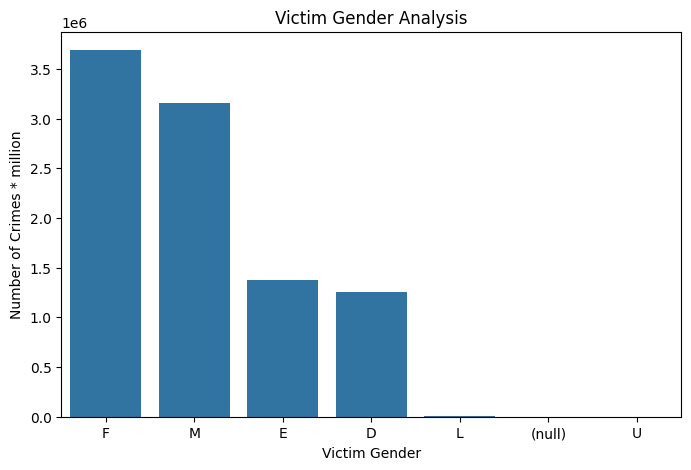

In [31]:
victim_gender = df.groupBy('VIC_SEX').count().orderBy('count', ascending=False)
victim_gender_pd = victim_gender.toPandas()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=victim_gender_pd, x='VIC_SEX', y='count')
plt.title('Victim Gender Analysis')
plt.xlabel('Victim Gender')
plt.ylabel('Number of Crimes * million')
plt.show()


Insight: Understanding the gender distribution among crime victims can aid in targeted crime prevention and support measures.

Analysis 11: Hourly Distribution of Crimes

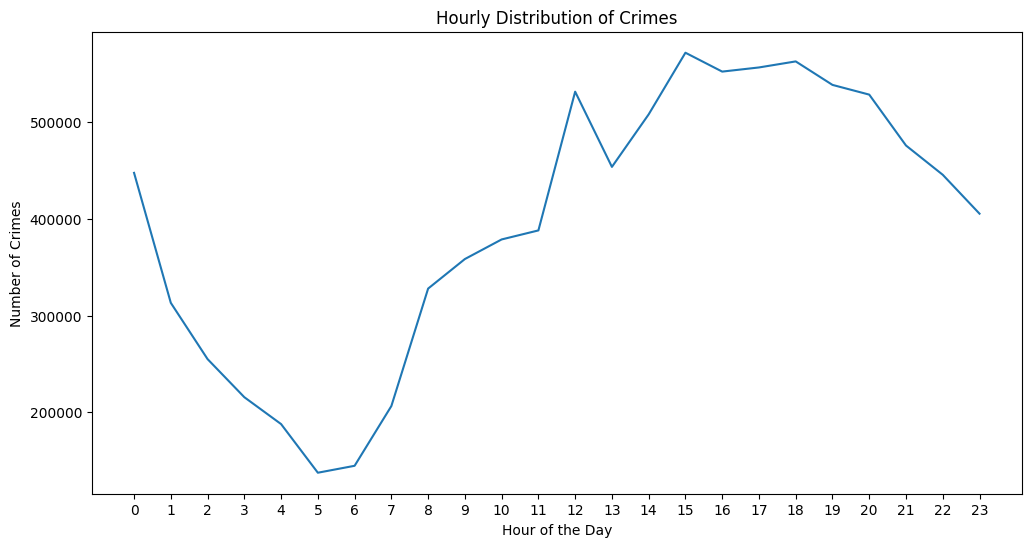

In [32]:
from pyspark.sql.functions import hour

df = df.withColumn('Hour', hour('CMPLNT_FR_TM'))
hourly_distribution = df.groupBy('Hour').count().orderBy('Hour')
hourly_distribution_pd = hourly_distribution.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_distribution_pd, x='Hour', y='count')
plt.title('Hourly Distribution of Crimes')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.show()


Insight: Reveals peak crime hours, which can be crucial for law enforcement patrol scheduling.

Analysis 12: Crime Correlation with Latitude and Longitude

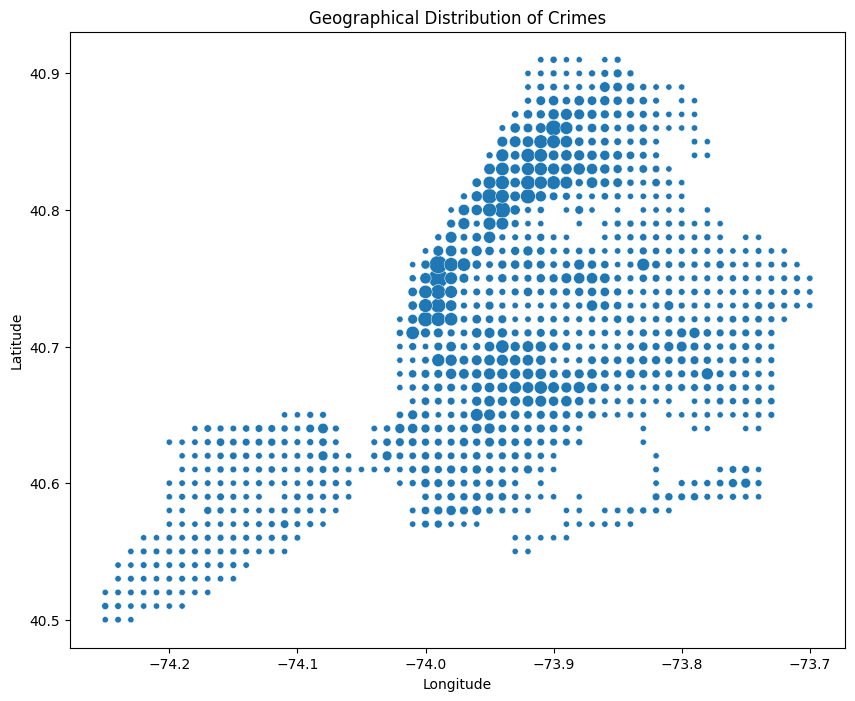

In [33]:
from pyspark.sql.functions import round

# Considering only records with valid coordinates
df_geo = df.filter((df['Latitude'] != 0) & (df['Longitude'] != 0))

# Rounding off latitude and longitude to 2 decimal places
df_geo = df_geo.withColumn('Latitude', round(df_geo['Latitude'], 2))
df_geo = df_geo.withColumn('Longitude', round(df_geo['Longitude'], 2))

# Aggregating based on rounded coordinates
geo_distribution = df_geo.groupBy('Latitude', 'Longitude').count().orderBy('count', ascending=False)
geo_distribution_pd = geo_distribution.toPandas()

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=geo_distribution_pd, x='Longitude', y='Latitude', size='count', legend=False, sizes=(20, 200))
plt.title('Geographical Distribution of Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Insight: This scatter plot will show crime concentration across different areas, highlighting potential crime hotspots.

In [34]:
from pyspark.sql.functions import corr

# Calculate correlation
correlation = df.stat.corr("X_COORD_CD", "Y_COORD_CD")

print(f"The correlation between X_COORD_CD and Y_COORD_CD is: {correlation}")


The correlation between X_COORD_CD and Y_COORD_CD is: 0.31136950337206337


**Modelling**

In [35]:
# Filter records for the year 2018
df_2018 = df.filter(df['CMPLNT_FR_DT'].contains('2018'))

# Get the number of records for the year 2018
num_records_2018 = df_2018.count()

df_2018.show()


+----------+------------+------------+-------------------+-----+--------------------+----------------+-----------+-------------+-----------------+-------------------+----------+----------+----------------+-----------------+--------------------+-------------+--------------+-------+---------+------------+----+
|CMPLNT_NUM|CMPLNT_FR_DT|CMPLNT_FR_TM|             RPT_DT|KY_CD|           OFNS_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|      BORO_NM|LOC_OF_OCCUR_DESC|         JURIS_DESC|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|             Lat_Lon|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|DayOfWeek|Age_Category|Hour|
+----------+------------+------------+-------------------+-----+--------------------+----------------+-----------+-------------+-----------------+-------------------+----------+----------+----------------+-----------------+--------------------+-------------+--------------+-------+---------+------------+----+
| 234748912|  06/27/2018|    00:01:00|2021-10-09 00:00:00|  116|      

In [36]:
# Get the number of rows (observations) in 2018
num_rows_2018 = df_2018.count()

# Get the number of columns (variables) in the DataFrame
num_columns = len(df_2018.columns)

print(f"Number of rows in 2018: {num_rows_2018}")
print(f"Number of columns: {num_columns}")


Number of rows in 2018: 462836
Number of columns: 22


**Machine Learning models for 2018 Data**

**Classification**


How accurate is the Multinomial Naive Bayes classifier in predicting crime categories based on text features extracted from borough names?

In [37]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, regexp_replace, col
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


df_2018 = df_2018.withColumn('BORO_NM', lower(col('BORO_NM')))  # Convert to lowercase
df_2018 = df_2018.withColumn('BORO_NM', regexp_replace(col('BORO_NM'), '[^\w\s]', ''))  # Remove punctuation


if 'words' in df_2018.columns:
    df_2018 = df_2018.drop('words')
# Tokenize the 'BORO_NM' column
tokenizer = Tokenizer(inputCol='BORO_NM', outputCol='words')
df_2018 = tokenizer.transform(df_2018)

# Remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered')
df_2018 = remover.transform(df_2018)

# Convert to Pandas DataFrame for scikit-learn compatibility
pandas_df = df_2018.select('filtered').toPandas()

# Convert list of tokens back to string
pandas_df['text'] = pandas_df['filtered'].apply(lambda x: ' '.join(x))

# Feature extraction with scikit-learn
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(pandas_df['text'])


Model 1: Predicting Crime Category (OFNS_DESC)

In [38]:
# Set target variable for Crime Category
y_category = df_2018.select('OFNS_DESC').toPandas()

# Split data into training and testing sets for Crime Category
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_tfidf, y_category, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier for Crime Category
clf_category = MultinomialNB()
clf_category.fit(X_train_cat, y_train_cat)

# Make predictions for Crime Category
y_pred_cat = clf_category.predict(X_test_cat)

# Evaluate the classifier for Crime Category
accuracy_cat = accuracy_score(y_test_cat, y_pred_cat)
report_cat = classification_report(y_test_cat, y_pred_cat)

print(f"Accuracy for Crime Category: {accuracy_cat}")
print("Classification Report for Crime Category:")
print(report_cat)


Accuracy for Crime Category: 0.19131881427707198
Classification Report for Crime Category:
                                      precision    recall  f1-score   support

                              (null)       0.00      0.00      0.00         1
                 ADMINISTRATIVE CODE       0.00      0.00      0.00       200
AGRICULTURE & MRKTS LAW-UNCLASSIFIED       0.00      0.00      0.00        22
      ALCOHOLIC BEVERAGE CONTROL LAW       0.00      0.00      0.00        19
               ANTICIPATORY OFFENSES       0.00      0.00      0.00         1
                               ARSON       0.00      0.00      0.00       161
        ASSAULT 3 & RELATED OFFENSES       0.00      0.00      0.00     10530
                     BURGLAR'S TOOLS       0.00      0.00      0.00        61
                            BURGLARY       0.00      0.00      0.00      2417
       CHILD ABANDONMENT/NON SUPPORT       0.00      0.00      0.00         3
      CRIMINAL MISCHIEF & RELATED OF       0.00   

How accurate is the Multinomial Naive Bayes classifier in predicting crime severity based on borough names' text features?

Model 2: Predicting Crime Severity (LAW_CAT_CD)

In [39]:
# Set target variable for Crime Severity
y_severity = df_2018.select('LAW_CAT_CD').toPandas()

# Split data into training and testing sets for Crime Severity
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X_tfidf, y_severity, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier for Crime Severity
clf_severity = MultinomialNB()
clf_severity.fit(X_train_sev, y_train_sev)

# Make predictions for Crime Severity
y_pred_sev = clf_severity.predict(X_test_sev)

# Evaluate the classifier for Crime Severity
accuracy_sev = accuracy_score(y_test_sev, y_pred_sev)
report_sev = classification_report(y_test_sev, y_pred_sev)

print(f"Accuracy for Crime Severity: {accuracy_sev}")
print("Classification Report for Crime Severity:")
print(report_sev)


Accuracy for Crime Severity: 0.5409860859044162
Classification Report for Crime Severity:
              precision    recall  f1-score   support

      FELONY       1.00      0.00      0.00     28408
 MISDEMEANOR       0.54      1.00      0.70     50077
   VIOLATION       0.00      0.00      0.00     14083

    accuracy                           0.54     92568
   macro avg       0.51      0.33      0.23     92568
weighted avg       0.60      0.54      0.38     92568



How accurately can borough names predict the location of crimes? Are certain boroughs more predictable than others based on their names?

Model 3: Predicting Location of Crime (BORO_NM)

In [40]:
# Set target variable for Location of Crime
y_location = df_2018.select('BORO_NM').toPandas()

# Split data into training and testing sets for Location of Crime
X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(X_tfidf, y_location, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier for Location of Crime
clf_location = MultinomialNB()
clf_location.fit(X_train_loc, y_train_loc)

# Make predictions for Location of Crime
y_pred_loc = clf_location.predict(X_test_loc)

# Evaluate the classifier for Location of Crime
accuracy_loc = accuracy_score(y_test_loc, y_pred_loc)
report_loc = classification_report(y_test_loc, y_pred_loc)

print(f"Accuracy for Location of Crime: {accuracy_loc}")
print("Classification Report for Location of Crime:")
print(report_loc)


Accuracy for Location of Crime: 1.0
Classification Report for Location of Crime:
               precision    recall  f1-score   support

        bronx       1.00      1.00      1.00     20150
     brooklyn       1.00      1.00      1.00     27317
    manhattan       1.00      1.00      1.00     22931
         null       1.00      1.00      1.00         1
       queens       1.00      1.00      1.00     18099
staten island       1.00      1.00      1.00      4070

     accuracy                           1.00     92568
    macro avg       1.00      1.00      1.00     92568
 weighted avg       1.00      1.00      1.00     92568



In [41]:
from sklearn.model_selection import cross_val_score

# Splitting the data
X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(X_tfidf, y_location, test_size=0.2, random_state=42)

# Initialize a Naive Bayes classifier
clf_location = MultinomialNB()

# Perform cross-validation
cv_scores = cross_val_score(clf_location, X_train_loc, y_train_loc.values.ravel(), cv=5)  # Using 5-fold cross-validation

# Train the classifier on the whole training set
clf_location.fit(X_train_loc, y_train_loc.values.ravel())

# Make predictions
y_pred_loc = clf_location.predict(X_test_loc)

# Evaluate the classifier
accuracy_loc = accuracy_score(y_test_loc, y_pred_loc)
report_loc = classification_report(y_test_loc, y_pred_loc)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
print(f"Accuracy for Location of Crime: {accuracy_loc}")
print("Classification Report for Location of Crime:")
print(report_loc)


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Accuracy for Location of Crime: 1.0
Classification Report for Location of Crime:
               precision    recall  f1-score   support

        bronx       1.00      1.00      1.00     20150
     brooklyn       1.00      1.00      1.00     27317
    manhattan       1.00      1.00      1.00     22931
         null       1.00      1.00      1.00         1
       queens       1.00      1.00      1.00     18099
staten island       1.00      1.00      1.00      4070

     accuracy                           1.00     92568
    macro avg       1.00      1.00      1.00     92568
 weighted avg       1.00      1.00      1.00     92568



How accurate is the RandomForestClassifier in predicting victim age groups based on various features, including categorical variables?


Target Variable:

Target variable: VIC_AGE_GROUP
This is the variable the model aims to predict. It represents the age group of the victim.
Input Variables:

Categorical Variables:
BORO_NM: Borough name where the crime occurred.
OFNS_DESC: Description of the offense.
VIC_RACE: Race of the victim.
VIC_SEX: Gender of the victim.
Numerical Variable:
KY_CD: Represents the offense key code, likely a numerical identifier for the type of offense.



```
# This is formatted as code
```

Victim Demographics Prediction

In [42]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Convert categorical variables to numerical using StringIndexer
indexer = StringIndexer(inputCols=["BORO_NM", "OFNS_DESC", "VIC_RACE", "VIC_SEX"],
                        outputCols=["BORO_NM_Index", "OFNS_DESC_Index", "VIC_RACE_Index", "VIC_SEX_Index"])

# OneHotEncoder to convert categorical indices into binary vectors
encoder = OneHotEncoder(inputCols=["BORO_NM_Index", "OFNS_DESC_Index", "VIC_RACE_Index", "VIC_SEX_Index"],
                        outputCols=["BORO_NM_Vec", "OFNS_DESC_Vec", "VIC_RACE_Vec", "VIC_SEX_Vec"])

# Assembling all features (including newly created categorical features)
assembler = VectorAssembler(inputCols=["BORO_NM_Vec", "OFNS_DESC_Vec", "KY_CD", "VIC_RACE_Vec", "VIC_SEX_Vec"], outputCol="features")

# StringIndexer for the target variable 'VIC_AGE_GROUP'
labelIndexer = StringIndexer(inputCol="VIC_AGE_GROUP", outputCol="label")

# Define a Pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler, labelIndexer])

# Transform data
output = pipeline.fit(df_2018).transform(df_2018)

# Split data into train and test sets
train_data, test_data = output.randomSplit([0.7, 0.3])

In [43]:
# Define the classifier model
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features")

# Train the model
rf_model = rf_classifier.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6081185446094105


**Regression**

Latitude Prediction of a crime event

Linear Regression:
Research Question: Investigating the Relationship Between Geographical Coordinates and Latitude
Input Variables: X_COORD_CD, Y_COORD_CD
Target Variable: Latitude


Polynomial Regression:
Research Question: Capturing Nonlinear Relationships in Geospatial Data
Input Variables: Polynomial expansion of X_COORD_CD, Y_COORD_CD
Target Variable: Latitude

Ridge Regression:
Research Question: Managing Overfitting in Spatial Regression Analysis
Input Variables: X_COORD_CD, Y_COORD_CD
Target Variable: Latitude

In [44]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Preparing the Data
assembler = VectorAssembler(inputCols=['X_COORD_CD', 'Y_COORD_CD'], outputCol='features')
output = assembler.transform(df_2018)
final_data = output.select("features", "Latitude")
train_data, test_data = final_data.randomSplit([0.7, 0.3])

# Function to evaluate the model
def evaluate_model(model, test_data):
    predictions = model.transform(test_data)
    evaluator = RegressionEvaluator(labelCol="Latitude", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"Model: {model.__class__.__name__} - RMSE on test data: {rmse}")


In [45]:
# Linear Regression
lr = LinearRegression(featuresCol='features', labelCol='Latitude')
lr_model = lr.fit(train_data)
evaluate_model(lr_model, test_data)

Model: LinearRegressionModel - RMSE on test data: 4.4686313084684174e-05


In [46]:
# Polynomial Regression
polyExpansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="polyFeatures")
train_data_poly = polyExpansion.transform(train_data)
test_data_poly = polyExpansion.transform(test_data)
lr_poly = LinearRegression(featuresCol='polyFeatures', labelCol='Latitude')
lr_poly_model = lr_poly.fit(train_data_poly)
evaluate_model(lr_poly_model, test_data_poly)

Model: LinearRegressionModel - RMSE on test data: 1.5699286147881443e-06


In [47]:
# Ridge Regression
ridge = GeneralizedLinearRegression(family="gaussian", link="identity", regParam=0.3, labelCol="Latitude")
ridge_model = ridge.fit(train_data)
evaluate_model(ridge_model, test_data)

Model: GeneralizedLinearRegressionModel - RMSE on test data: 0.06423861370564934


Time-Based Predictions

In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, minute
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

#Convert time to numerical format (e.g., minutes after midnight)
time_to_minutes = (hour("CMPLNT_FR_TM") * 60) + minute("CMPLNT_FR_TM")
df_2018 = df_2018.withColumn("TimeInMinutes", time_to_minutes)

# Handle Categorical Variables
# StringIndexer for converting string to numerical indices
indexer = StringIndexer(inputCols=["BORO_NM"], outputCols=["BORO_NM_Index"])

# OneHotEncoder to convert categorical indices into a binary vector
encoder = OneHotEncoder(inputCols=["BORO_NM_Index"], outputCols=["BORO_NM_Vec"])

# Assembling features (including categorical features after transformation)
assembler = VectorAssembler(inputCols=["BORO_NM_Vec", "KY_CD"], outputCol="features")

# Define a Pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Transform data
output = pipeline.fit(df_2018).transform(df_2018)
final_data = output.select("features", "TimeInMinutes")

# Split data into train and test sets
train_data, test_data = final_data.randomSplit([0.7, 0.3])

In [49]:
def evaluate_model(model, test_data):
    predictions = model.transform(test_data)
    evaluator = RegressionEvaluator(labelCol="TimeInMinutes", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"Model: {model.__class__.__name__} - RMSE: {rmse}")

In [50]:
# Linear Regression
lr = LinearRegression(featuresCol='features', labelCol='TimeInMinutes')
lr_model = lr.fit(train_data)
evaluate_model(lr_model, test_data)

Model: LinearRegressionModel - RMSE: 395.3976859524314


In [51]:
# Ridge Regression
ridge = GeneralizedLinearRegression(family="gaussian", link="identity", regParam=0.3, labelCol="TimeInMinutes")
ridge_model = ridge.fit(train_data)
evaluate_model(ridge_model, test_data)

Model: GeneralizedLinearRegressionModel - RMSE: 395.3957023832358


**Time Series Analysis**: Analyze crime trends over time to forecast future crime rates

In [52]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, year, month, dayofmonth
from pyspark.sql.types import DateType


# Ensure your date column (e.g., 'CMPLNT_FR_DT') is in the appropriate format
df_2018 = df_2018.withColumn('Date', to_date(col('CMPLNT_FR_DT'), 'MM/dd/yyyy'))

# Aggregate data to get monthly crime counts
monthly_data = df_2018.groupBy(year("Date").alias("Year"), month("Date").alias("Month")).count().orderBy("Year", "Month")
monthly_data.show()

+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2018|    1|37755|
|2018|    2|34598|
|2018|    3|37407|
|2018|    4|37509|
|2018|    5|41211|
|2018|    6|39939|
|2018|    7|41825|
|2018|    8|41491|
|2018|    9|39166|
|2018|   10|39159|
|2018|   11|36143|
|2018|   12|36633|
+----+-----+-----+



In [53]:
monthly_data = monthly_data.withColumn("YearMonth", col("Year") * 100 + col("Month"))  # Combine Year and Month
monthly_data.select("YearMonth", "count").orderBy("YearMonth").show()


+---------+-----+
|YearMonth|count|
+---------+-----+
|   201801|37755|
|   201802|34598|
|   201803|37407|
|   201804|37509|
|   201805|41211|
|   201806|39939|
|   201807|41825|
|   201808|41491|
|   201809|39166|
|   201810|39159|
|   201811|36143|
|   201812|36633|
+---------+-----+



In [54]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Assemble features (Year and Month in this case)
assembler = VectorAssembler(inputCols=["Year", "Month"], outputCol="features")
data_with_features = assembler.transform(monthly_data)

# Split data into training and testing
train_data, test_data = data_with_features.randomSplit([0.7, 0.3])

# Define and train the model
lr = LinearRegression(featuresCol='features', labelCol='count')
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)
predictions.select("YearMonth", "prediction").show()


+---------+------------------+
|YearMonth|        prediction|
+---------+------------------+
|   201806| 38291.90306122449|
|   201807|38480.030612244926|
|   201812| 39420.66836734711|
+---------+------------------+



**Geo-Spatial Analysis**

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


# Assuming df_2018 is your DataFrame
df_2018 = df_2018.select("Latitude", "Longitude").filter(col("Latitude").isNotNull() & col("Longitude").isNotNull())

# Convert latitude and longitude to DoubleType
df_2018 = df_2018.withColumn("Latitude", df_2018["Latitude"].cast(DoubleType()))
df_2018 = df_2018.withColumn("Longitude", df_2018["Longitude"].cast(DoubleType()))


In [57]:
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.7 MB/s eta 0:00:00


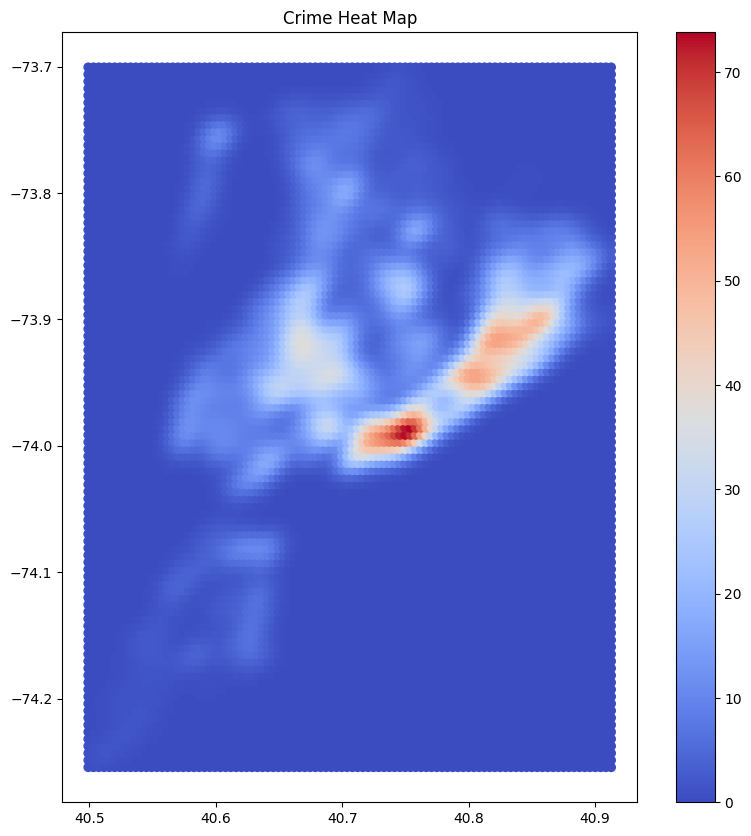

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Assuming you have a GeoDataFrame named gdf with 'Latitude' and 'Longitude' columns
gdf = df_2018
# Convert the PySpark DataFrame to a Pandas DataFrame
gdf_pd = gdf.toPandas()

# Calculate KDE for crime locations using the Pandas DataFrame
kde = gaussian_kde(gdf_pd[['Latitude', 'Longitude']].T)

# Create a grid of points for the heatmap
x, y = np.meshgrid(np.linspace(gdf_pd['Latitude'].min(), gdf_pd['Latitude'].max(), 100),
                   np.linspace(gdf_pd['Longitude'].min(), gdf_pd['Longitude'].max(), 100))
grid_coords = np.vstack([x.ravel(), y.ravel()])
grid_density = kde(grid_coords)

# Create a GeoDataFrame for the heatmap
heat_data = {'Latitude': grid_coords[0], 'Longitude': grid_coords[1], 'Density': grid_density}
heat_gdf = gpd.GeoDataFrame(heat_data, geometry=gpd.points_from_xy(grid_coords[0], grid_coords[1]))

# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 10))
heat_gdf.plot(column='Density', cmap='coolwarm', ax=ax, legend=True)
plt.title("Crime Heat Map")
plt.show()

In [63]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 5.2 MB/s eta 0:00:00


In [64]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Sample the data if necessary
df_2018 = df_2018.sample(fraction=0.1).toPandas()

# Ensure that Latitude and Longitude are numeric
df_2018['Latitude'] = pd.to_numeric(df_2018['Latitude'], errors='coerce')
df_2018['Longitude'] = pd.to_numeric(df_2018['Longitude'], errors='coerce')

# Drop rows where Latitude or Longitude is NaN
df_2018.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# Create a base map
map = folium.Map(location=[df_2018['Latitude'].mean(), df_2018['Longitude'].mean()], zoom_start=10)

# Add HeatMap
HeatMap(data=df_2018[['Latitude', 'Longitude']], radius=10).add_to(map)

# Display the map
map

In [65]:
#spark.stop